## Taxi Dataset

In [34]:
%matplotlib inline
import plotly
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import ipywidgets as widgets

from shapely import wkt
from tabulate import tabulate
from sklearn import datasets
from dask import dataframe as dd
from shapely.geometry import Point
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets
from matplotlib.widgets import Slider
from IPython.display import display
from folium.plugins import HeatMap, MarkerCluster

## Preprocessing

In [35]:
taxi_file = '/home/rares/Desktop/Master/DataViz/Milestone1/dataset/green_taxi.csv'
zones_file = '/home/rares/Desktop/Master/DataViz/Milestone1/dataset/taxi_zones.csv'
taxi_zones_file = '/home/rares/Desktop/Master/DataViz/Milestone1/dataset/taxi_zone_lookup.csv'

In [36]:
def custom_taxi_date_parser(date_str):
    return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S')

In [37]:
taxi = pd.read_csv(taxi_file, parse_dates=['lpep_pickup_datetime', 'lpep_dropoff_datetime'], date_parser=custom_taxi_date_parser)
taxi

/tmp/ipykernel_4875/597934344.py:1: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



,Unnamed: 0,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Year
0,0,2.0,2019-02-01 00:10:19,2019-02-01 00:21:43,92,135,2.79,11.00,0.5,0.5,3.08,0.0,0.3,15.38,2019
1,1,2.0,2019-02-01 00:02:16,2019-02-01 00:24:37,66,36,4.46,17.50,0.5,0.5,3.76,0.0,0.3,22.56,2019
2,2,2.0,2019-02-01 00:37:19,2019-02-01 00:43:07,255,112,1.26,6.00,0.5,0.5,1.46,0.0,0.3,8.76,2019
3,3,1.0,2019-02-01 00:10:10,2019-02-01 00:12:21,75,238,0.70,4.00,0.5,0.5,0.00,0.0,0.3,5.30,2019
4,4,1.0,2019-02-01 00:30:19,2019-02-01 00:46:14,75,48,3.90,14.50,0.5,0.5,0.00,0.0,0.3,15.80,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9687253,9687253,2.0,2022-12-31 23:33:00,2022-12-31 23:49:00,33,79,3.53,20.72,0.0,0.0,4.89,0.0,1.0,29.36,2022
9687254,9687254,2.0,2022-12-31 23:29:00,2023-01-01 00:01:00,49,197,8.94,39.01,0.0,0.0,8.00,0.0,1.0,48.01,2022
9687255,9687255,2.0,2022-12-31 23:05:00,2022-12-31 23:12:00,54,181,1.27,12.11,0.0,0.0,2.62,0.0,1.0,15.73,2022
9687256,9687256,2.0,2022-12-31 23:03:00,2022-12-31 23:18:00,7,129,2.23,15.51,0.0,0.0,3.30,0.0,1.0,19.81,2022


In [38]:
zones = pd.read_csv(zones_file)
zones['the_geom'] = zones['the_geom'].apply(wkt.loads)
zones['centroid'] = zones['the_geom'].apply(lambda x : x.centroid)
zones['longitude'] = zones['centroid'].apply(lambda x : x.x)
zones['latitude'] = zones['centroid'].apply(lambda x : x.y)
zones

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough,centroid,longitude,latitude
0,1,0.116357,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.000782,Newark Airport,1,EWR,POINT (-74.17400027276304 40.691831206401325),-74.174000,40.691831
1,2,0.433470,MULTIPOLYGON (((-73.82337597260663 40.63898704...,0.004866,Jamaica Bay,2,Queens,POINT (-73.83129854302213 40.61674529165957),-73.831299,40.616745
2,3,0.084341,MULTIPOLYGON (((-73.84792614099985 40.87134223...,0.000314,Allerton/Pelham Gardens,3,Bronx,POINT (-73.84742223236718 40.86447368477527),-73.847422,40.864474
3,4,0.043567,MULTIPOLYGON (((-73.97177410965318 40.72582128...,0.000112,Alphabet City,4,Manhattan,POINT (-73.97696825691759 40.72375214158459),-73.976968,40.723752
4,5,0.092146,MULTIPOLYGON (((-74.17421738099989 40.56256808...,0.000498,Arden Heights,5,Staten Island,POINT (-74.18848410184935 40.55265928694546),-74.188484,40.552659
...,...,...,...,...,...,...,...,...,...,...
258,256,0.067915,MULTIPOLYGON (((-73.95834207500002 40.71330630...,0.000169,Williamsburg (South Side),256,Brooklyn,POINT (-73.95990462730536 40.710879933377214),-73.959905,40.710880
259,259,0.126750,MULTIPOLYGON (((-73.85107116191898 40.91037152...,0.000395,Woodlawn/Wakefield,259,Bronx,POINT (-73.85221545370123 40.897932025294516),-73.852215,40.897932
260,260,0.133514,MULTIPOLYGON (((-73.90175373399988 40.76077547...,0.000422,Woodside,260,Queens,POINT (-73.90630644197891 40.74423471780134),-73.906306,40.744235
261,261,0.027120,MULTIPOLYGON (((-74.01332610899988 40.70503078...,0.000034,World Trade Center,261,Manhattan,POINT (-74.01302277174901 40.70913894067164),-74.013023,40.709139


In [39]:
taxi_zones = pd.read_csv(taxi_zones_file)
taxi_zones

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


In [40]:
# Zones that do not have correspondent in NYC
entries_per_zones = taxi_zones
entries_per_zones['Total Number'] = 1
entries_per_zones[entries_per_zones['service_zone'].isna()]

,LocationID,Borough,Zone,service_zone,Total Number
263,264,Unknown,NaN,NaN,1
264,265,NaN,Outside of NYC,NaN,1


In [41]:
# Get the number of zones per Borough
entries_per_zones = entries_per_zones[~entries_per_zones['Zone'].isna()]
entries_per_zones.loc[entries_per_zones['Borough'].isna(), 'Borough'] = 'External'
entries_per_zones = entries_per_zones.groupby('Borough').count()
entries_per_zones.drop(columns=['LocationID', 'Zone', 'service_zone'], inplace=True)
entries_per_zones

,Total Number
Borough,
Bronx,43
Brooklyn,61
EWR,1
External,1
Manhattan,69
Queens,69
Staten Island,20


Data preprocessing:
- filter out data which is outside NYC
- filter out data is the trip_distance field contains unrealistic values

In [42]:
# Check if there are rides from an known zones
known_routes = taxi[(taxi['PULocationID'] < 264) & (taxi['DOLocationID'] < 264)]
known_routes = known_routes[(known_routes['trip_distance'] >= 0) & (known_routes['trip_distance'] < 100)]
known_routes['Month'] = known_routes['lpep_pickup_datetime'].dt.month
known_routes.drop(columns=['Unnamed: 0', 'VendorID'], inplace=True)
known_routes

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Year,Month
0,2019-02-01 00:10:19,2019-02-01 00:21:43,92,135,2.79,11.00,0.5,0.5,3.08,0.0,0.3,15.38,2019,2
1,2019-02-01 00:02:16,2019-02-01 00:24:37,66,36,4.46,17.50,0.5,0.5,3.76,0.0,0.3,22.56,2019,2
2,2019-02-01 00:37:19,2019-02-01 00:43:07,255,112,1.26,6.00,0.5,0.5,1.46,0.0,0.3,8.76,2019,2
3,2019-02-01 00:10:10,2019-02-01 00:12:21,75,238,0.70,4.00,0.5,0.5,0.00,0.0,0.3,5.30,2019,2
4,2019-02-01 00:30:19,2019-02-01 00:46:14,75,48,3.90,14.50,0.5,0.5,0.00,0.0,0.3,15.80,2019,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9687253,2022-12-31 23:33:00,2022-12-31 23:49:00,33,79,3.53,20.72,0.0,0.0,4.89,0.0,1.0,29.36,2022,12
9687254,2022-12-31 23:29:00,2023-01-01 00:01:00,49,197,8.94,39.01,0.0,0.0,8.00,0.0,1.0,48.01,2022,12
9687255,2022-12-31 23:05:00,2022-12-31 23:12:00,54,181,1.27,12.11,0.0,0.0,2.62,0.0,1.0,15.73,2022,12
9687256,2022-12-31 23:03:00,2022-12-31 23:18:00,7,129,2.23,15.51,0.0,0.0,3.30,0.0,1.0,19.81,2022,12


## Exploratory Data Analysis

In [43]:
# Group routes by date (Year - Month)
grouped_routes_by_date = known_routes.groupby(['Month', 'Year']).size().reset_index(name='count')
grouped_routes_by_date = grouped_routes_by_date.sort_values(by=['Year', 'Month'])

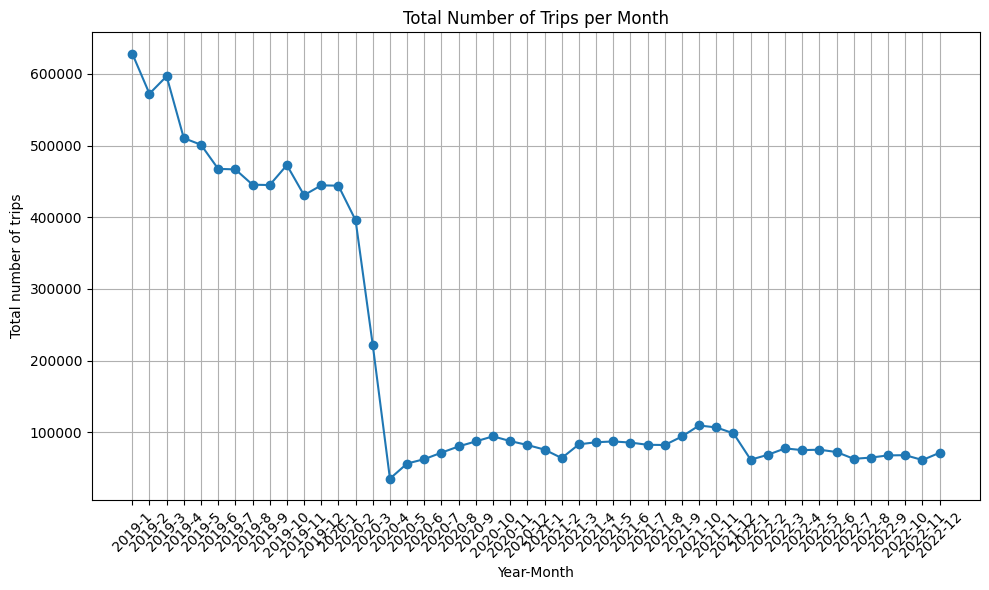

In [44]:
# Plot the timeseries for the number of trips per month from 2019 to 2022
plt.figure(figsize=(10, 6))
plt.plot(grouped_routes_by_date['Year'].astype(str) + '-' + grouped_routes_by_date['Month'].astype(str), grouped_routes_by_date['count'], marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Total number of trips')
plt.title('Total Number of Trips per Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('timeseries_trip.png')
plt.show()

In [45]:
# Number of rides per month for each starting point
top_starts = taxi_zones['Zone'].unique()
routes = known_routes[['PULocationID', 'trip_distance', 'Year', 'Month']]
routes_zones = pd.merge(routes, taxi_zones, left_on='PULocationID', right_on='LocationID').drop(columns=['PULocationID','LocationID', 'service_zone', 'Borough', 'Total Number'])
routes_zones = routes_zones[routes_zones['Zone'].isin(top_starts)]
groupped_routes_zones = routes_zones.groupby(['Year', 'Month', 'Zone']).size().reset_index(name='count')

def plot_timeseries_per_zone(zone):
    plt.figure(figsize=(10, 6))
    # colors = sns.color_palette('husl', n_colors=10)
    groupped = groupped_routes_zones[groupped_routes_zones['Zone'] == zone].sort_values(by=['Year', 'Month'])
    groupped['date'] = groupped['Year'].astype(str) + '-' + groupped['Month'].astype(str)
    sns.barplot(x=groupped['date'], y=groupped["count"])
    plt.title(f'Number of trips per month starting from {zone}')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of trips')
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

interact(plot_timeseries_per_zone, zone=widgets.Dropdown(options=routes_zones['Zone'].unique(), description='Date:'))

interactive(children=(Dropdown(description='Date:', options=('Flushing', 'DUMBO/Vinegar Hill', 'Williamsburg (…

<function __main__.plot_timeseries_per_zone(zone)>

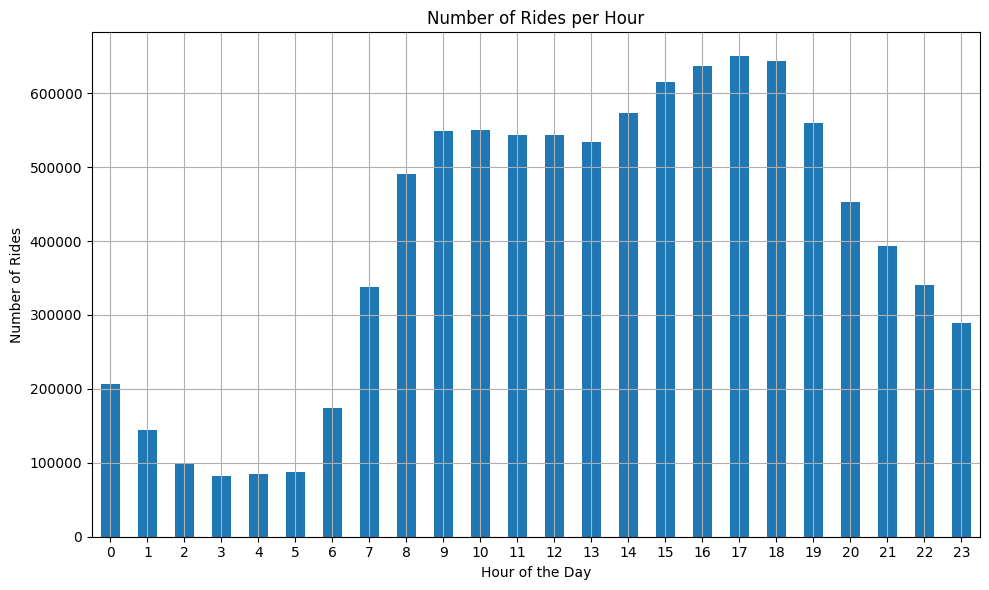

In [46]:
# Compute the number of rides based on the hour
daytime = known_routes
daytime['hour'] = daytime['lpep_pickup_datetime'].dt.hour


# Plot the time series
plt.figure(figsize=(10, 6))  # Set the figure size
daytime['hour'].value_counts().sort_index().plot(kind='bar')

plt.title('Number of Rides per Hour')  # Set the title
plt.xlabel('Hour of the Day')  # Set the x-axis label
plt.ylabel('Number of Rides')  # Set the y-axis label
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(True)  # Add grid lines
plt.tight_layout()  # Adjust layout
plt.savefig('number_rides_per_hour.png')
plt.show()  # Show the plot

In [47]:
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
part_of_day_order = ['Morning', 'Afternoon', 'Evening', 'Night']

# Create a new column for day of ther
groupby_day = known_routes
groupby_day['day'] = groupby_day['lpep_pickup_datetime'].apply(lambda x : days_of_week[x.weekday()])

# Split a day in 4 parts (Morning, AfterNoon, Evening, Night)
groupby_day.loc[(daytime['lpep_pickup_datetime'].dt.hour >= 2) & (daytime['lpep_pickup_datetime'].dt.hour < 12) , 'partOfDay'] = 'Morning'
groupby_day.loc[(daytime['lpep_pickup_datetime'].dt.hour >= 12) & (daytime['lpep_pickup_datetime'].dt.hour < 16) , 'partOfDay'] = 'Afternoon'
groupby_day.loc[(daytime['lpep_pickup_datetime'].dt.hour >= 16) & (daytime['lpep_pickup_datetime'].dt.hour < 19) , 'partOfDay'] = 'Evening'
groupby_day.loc[(daytime['lpep_pickup_datetime'].dt.hour >= 19) | (daytime['lpep_pickup_datetime'].dt.hour < 2) , 'partOfDay'] = 'Night'

# Compute the number of trips per part of the day within a specific day of the week
part_of_day = groupby_day.groupby(['day', 'partOfDay']).size().reset_index(name='Count')
part_of_day['day'] = pd.Categorical(part_of_day['day'], categories=days_of_week, ordered=True)
part_of_day['partOfDay'] = pd.Categorical(part_of_day['partOfDay'], categories=part_of_day_order, ordered=True)

pivot_df = part_of_day.pivot(index='day', columns='partOfDay', values='Count')

# Reorder columns to match the desired order
pivot_df = pivot_df[['Morning', 'Afternoon', 'Evening', 'Night']]

<Figure size 1000x600 with 0 Axes>

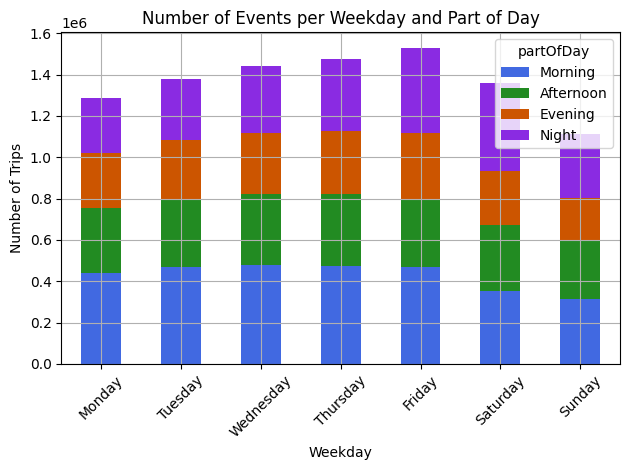

In [48]:
# Plot the bar plot for each day of the week
plt.figure(figsize=(10, 6))
colors = [(65/255, 105/255, 225/255),  # Royal Blue
          (34/255, 139/255, 34/255),   # Forest Green
          (204/255, 85/255, 0),        # Burnt Orange
          (138/255, 43/255, 226/255)]  # Deep Purple
pivot_df.plot(kind='bar', stacked=True, color=colors)

plt.title('Number of Events per Weekday and Part of Day')
plt.xlabel('Weekday')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('number_events_weekday.png')
plt.show()

In [49]:
# Top 10 pickup zones per year
routes = known_routes.groupby(['Year', 'PULocationID']).size().reset_index(name='count')
merged = pd.merge(routes, taxi_zones, left_on='PULocationID', right_on='LocationID').sort_values(by=['count'], ascending=False).drop(columns=['LocationID', 'service_zone', 'PULocationID', 'Borough'])
merged = merged.groupby('Year').head(10).reset_index(drop=True).sort_index()
pivot_table = merged.pivot_table(index=merged.groupby('Year').cumcount() + 1, columns='Year', values='Zone', aggfunc=lambda x: ', '.join(x))

pivot_table.reset_index(inplace=True)

# Convert pivot table to a list of lists for tabulate
table_data = pivot_table.values.tolist()

# Column headers
headers = pivot_table.columns.tolist()

# Print the pivot table
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))


╒═════════╤══════════════════════╤══════════════════════════╤══════════════════════════╤══════════════════════════╕
│   index │ 2019                 │ 2020                     │ 2021                     │ 2022                     │
╞═════════╪══════════════════════╪══════════════════════════╪══════════════════════════╪══════════════════════════╡
│       1 │ East Harlem North    │ East Harlem North        │ East Harlem North        │ East Harlem North        │
├─────────┼──────────────────────┼──────────────────────────┼──────────────────────────┼──────────────────────────┤
│       2 │ East Harlem South    │ East Harlem South        │ East Harlem South        │ East Harlem South        │
├─────────┼──────────────────────┼──────────────────────────┼──────────────────────────┼──────────────────────────┤
│       3 │ Central Harlem       │ Central Harlem           │ Central Harlem           │ Central Harlem           │
├─────────┼──────────────────────┼──────────────────────────┼───────────

In [50]:
#Top 10 drop off zones per year
routes = known_routes.groupby(['Year', 'DOLocationID']).size().reset_index(name='count')
merged = pd.merge(routes, taxi_zones, left_on='DOLocationID', right_on='LocationID').sort_values(by=['count'], ascending=False).drop(columns=['LocationID', 'service_zone', 'DOLocationID', 'Borough'])
merged = merged.groupby('Year').head(10).reset_index(drop=True).sort_index()
pivot_table = merged.pivot_table(index=merged.groupby('Year').cumcount() + 1, columns='Year', values='Zone', aggfunc=lambda x: ', '.join(x))

pivot_table.reset_index(inplace=True)

# Convert pivot table to a list of lists for tabulate
table_data = pivot_table.values.tolist()

# Column headers
headers = pivot_table.columns.tolist()

# Print the pivot table
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))


╒═════════╤══════════════════════╤═══════════════════════╤══════════════════════════╤═══════════════════════╕
│   index │ 2019                 │ 2020                  │ 2021                     │ 2022                  │
╞═════════╪══════════════════════╪═══════════════════════╪══════════════════════════╪═══════════════════════╡
│       1 │ East Harlem North    │ East Harlem North     │ East Harlem North        │ East Harlem North     │
├─────────┼──────────────────────┼───────────────────────┼──────────────────────────┼───────────────────────┤
│       2 │ Central Harlem North │ Central Harlem North  │ East Harlem South        │ East Harlem South     │
├─────────┼──────────────────────┼───────────────────────┼──────────────────────────┼───────────────────────┤
│       3 │ Central Harlem       │ East Harlem South     │ Central Harlem North     │ Central Harlem        │
├─────────┼──────────────────────┼───────────────────────┼──────────────────────────┼───────────────────────┤
│       4 

Can we check if there is correlation in our data?

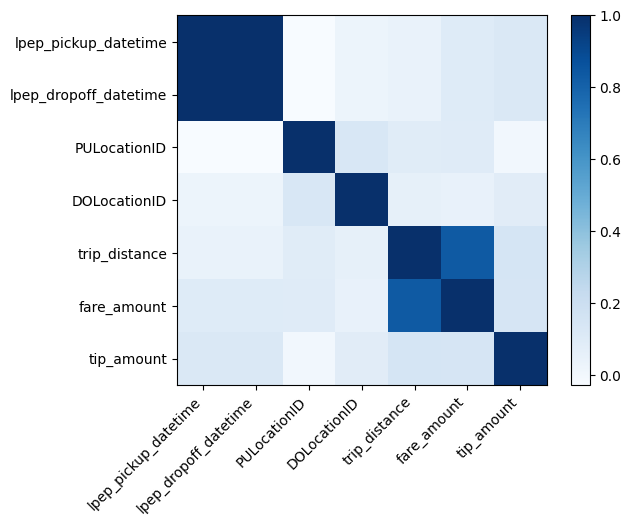

In [51]:
selection = known_routes[['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_distance', 'fare_amount',	'tip_amount']]
matrix = selection.corr()

#plotting correlation matrix
plt.imshow(matrix, cmap='Blues')

#adding colorbar
plt.colorbar()

#extracting variable names
variables = []
for i in matrix.columns:
  variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()

There is correlation between start time and stop time as well as between fare amount and trip distance which are obvious.

In [52]:
# Create a categorical variable which indicates those 3 periods: pre-, during, post- pandemic
order_pandemic = ['Before Pandemic', 'During Pandemic', 'After Pandemic']
pandemic_routes = known_routes
pandemic_routes['pandemic'] = 'Before Pandemic'
pandemic_routes.loc[(pandemic_routes['Year'] >= 2020) & (pandemic_routes['Year'] <= 2021), 'pandemic'] = 'During Pandemic'
pandemic_routes.loc[pandemic_routes['Year'] == 2022, 'pandemic'] = 'After Pandemic'
pandemic_routes = pandemic_routes.groupby(['pandemic'])['trip_distance'].mean()
pandemic_routes = pandemic_routes.reindex(order_pandemic)

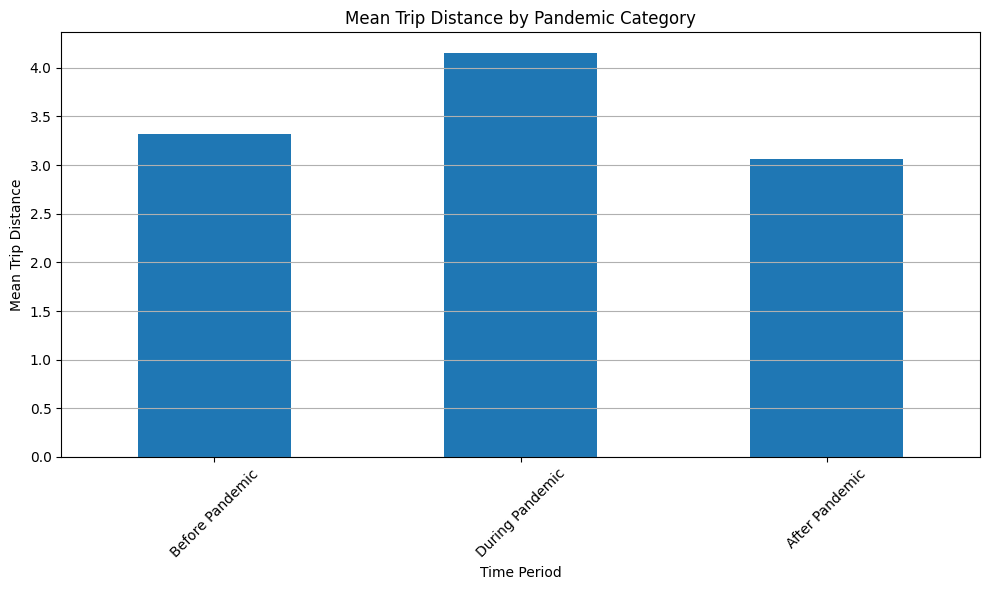

In [53]:
# Plot Average Distance per each period
pandemic_routes.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Trip Distance by Pandemic Category')
plt.xlabel('Time Period')
plt.ylabel('Mean Trip Distance')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('mean_distance_by_period.png')
plt.show()

In [54]:
# Average distance per month for each starting point
top_starts = taxi_zones['Zone'].unique()
routes = known_routes[['PULocationID', 'trip_distance', 'Year', 'Month']]
routes_zones = pd.merge(routes, taxi_zones, left_on='PULocationID', right_on='LocationID').drop(columns=['PULocationID','LocationID', 'service_zone', 'Borough', 'Total Number'])
routes_zones = routes_zones[routes_zones['Zone'].isin(top_starts)]
routes_zones = routes_zones.groupby(['Year', 'Month', 'Zone']).mean().reset_index()

def plot_average_distance_by_pickup(zone):
    plt.figure(figsize=(10, 6))
    # colors = sns.color_palette('husl', n_colors=10)
    groupped = routes_zones[routes_zones['Zone'] == zone].sort_values(by=['Year', 'Month'])
    groupped['date'] = groupped['Year'].astype(str) + '-' + groupped['Month'].astype(str)
    sns.barplot(x=groupped['date'], y=groupped["trip_distance"])
    plt.title(f'Average Trip Distance per Month for Starting Point {zone}')
    plt.xlabel('Time')
    plt.ylabel('Average Trip Distance')
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

interact(plot_average_distance_by_pickup, zone=widgets.Dropdown(options=routes_zones['Zone'].unique(), description='Pickup-point:'))

interactive(children=(Dropdown(description='Pickup-point:', options=('Allerton/Pelham Gardens', 'Alphabet City…

<function __main__.plot_average_distance_by_pickup(zone)>

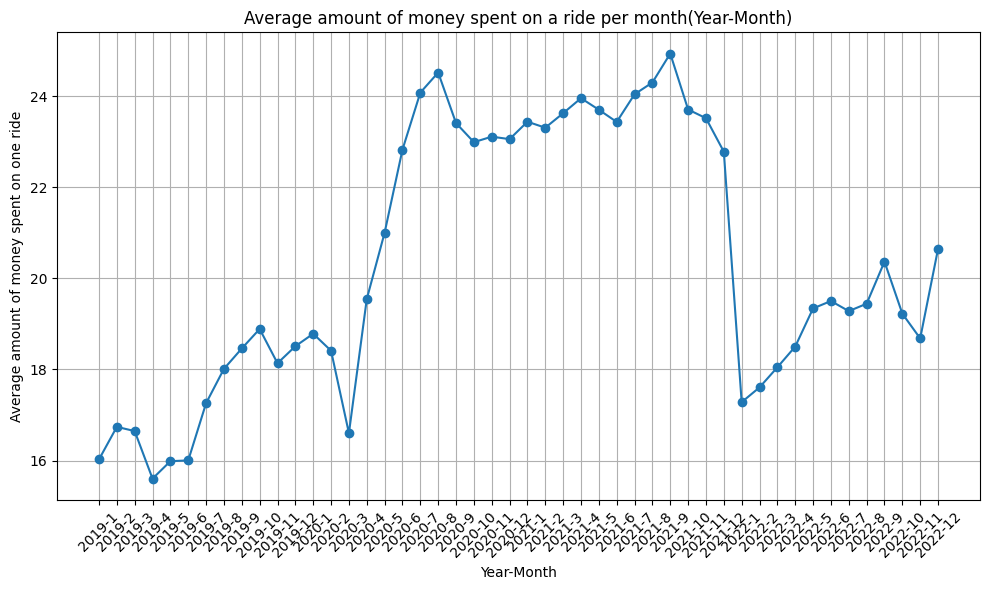

In [55]:
# Check the amount of money spent: fare_amount + fees + tips. (Check this trend)
grouped_routes_by_date = known_routes.groupby(['Month', 'Year'])['total_amount'].mean().reset_index(name='mean')
grouped_routes_by_date = grouped_routes_by_date.sort_values(by=['Year', 'Month'])

plt.figure(figsize=(10, 6))
plt.plot(grouped_routes_by_date['Year'].astype(str) + '-' + grouped_routes_by_date['Month'].astype(str), grouped_routes_by_date['mean'], marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Average amount of money spent on one ride')
plt.title('Average amount of money spent on a ride per month(Year-Month)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('average_amount_money_trip.png')
plt.show()

Is the above result influenced by the distance? Did the citizens traveled on longer distances?
Less trips but longer?

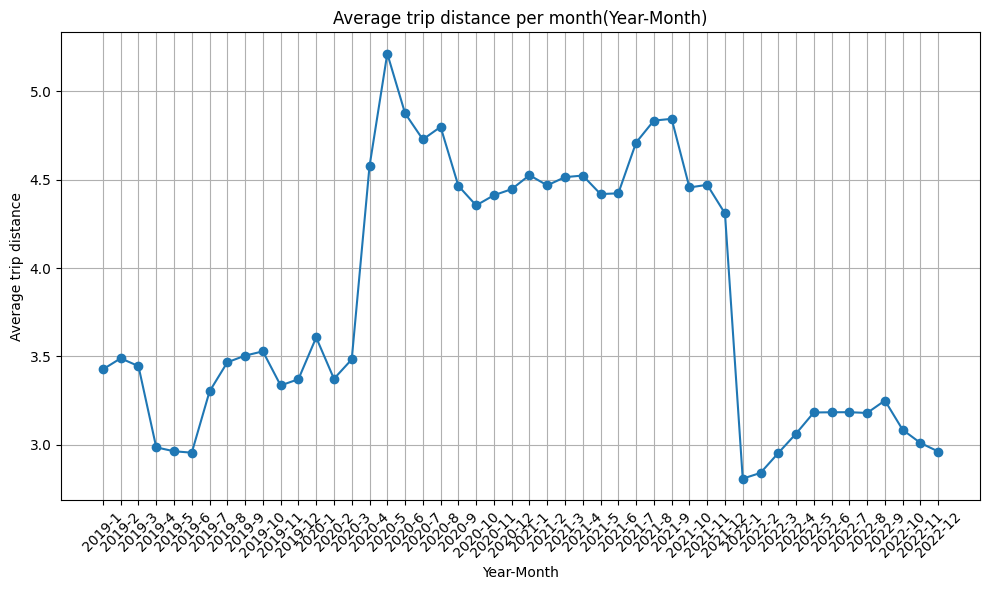

In [56]:
grouped_routes_by_date = known_routes.groupby(['Month', 'Year'])['trip_distance'].mean().reset_index(name='mean')
grouped_routes_by_date = grouped_routes_by_date.sort_values(by=['Year', 'Month'])

plt.figure(figsize=(10, 6))
plt.plot(grouped_routes_by_date['Year'].astype(str) + '-' + grouped_routes_by_date['Month'].astype(str), grouped_routes_by_date['mean'], marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Average trip distance')
plt.title('Average trip distance per month(Year-Month)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('average_distance_month.png')
plt.show()

It seems to follow closely the pattern shown in the plot of average distance per month

In [57]:
# Take the centroids for each zone and compute a new colomn which contains the route
routes = known_routes.groupby(['Year','PULocationID', 'DOLocationID']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)
merged = pd.merge(routes, taxi_zones, left_on='PULocationID', right_on='LocationID').drop(columns=['PULocationID', 'service_zone', 'LocationID'])
merged = merged.rename(columns={'Borough':'Source Borough', 'Zone':'Source Zone'})
merged = pd.merge(merged, taxi_zones, left_on='DOLocationID', right_on='LocationID').drop(columns=['DOLocationID', 'service_zone', 'LocationID'])
merged = merged.rename(columns={'Borough':'Destination Borough', 'Zone':'Destination Zone'}).sort_values(by=['count'], ascending=False).reset_index().drop(columns=['index'])
merged['route'] = merged['Source Zone'] + " - " + merged['Destination Zone']  

## Take top 3 routes from each year
merged_2019 = merged[merged['Year'] == 2019].drop(columns=['Destination Borough', 'Source Borough', 'Destination Zone', 'Source Zone', 'Total Number_x', 'Total Number_y']).head(3)
merged_2020 = merged[merged['Year'] == 2020].drop(columns=['Destination Borough', 'Source Borough', 'Destination Zone', 'Source Zone', 'Total Number_x', 'Total Number_y']).head(3)
merged_2021 = merged[merged['Year'] == 2021].drop(columns=['Destination Borough', 'Source Borough', 'Destination Zone', 'Source Zone', 'Total Number_x', 'Total Number_y']).head(3)
merged_2022 = merged[merged['Year'] == 2022].drop(columns=['Destination Borough', 'Source Borough', 'Destination Zone', 'Source Zone', 'Total Number_x', 'Total Number_y']).head(3)
concat = pd.concat([merged_2019, merged_2020, merged_2021, merged_2022])
top_routes = concat['route'].unique()[:5]

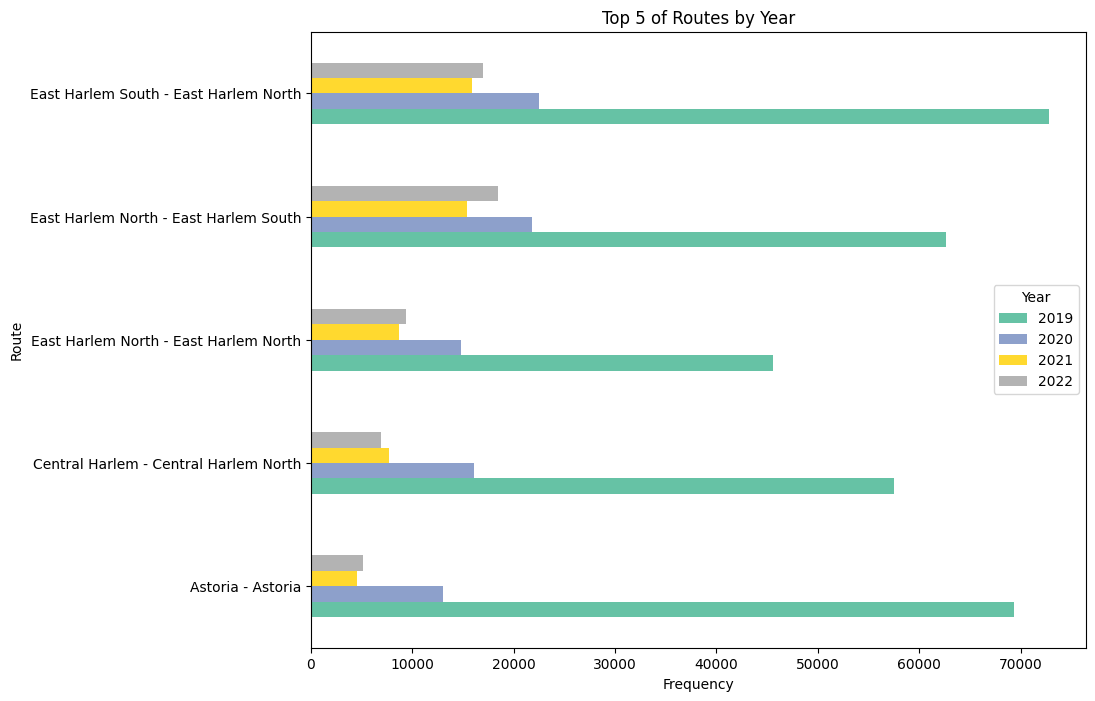

In [58]:
pivot_df = merged[merged['route'].isin(top_routes)].pivot(index='route', columns='Year', values='count')

# Plotting
pivot_df.plot(kind='barh', figsize=(10, 8), colormap='Set2')
plt.xlabel('Frequency')
plt.ylabel('Route')
plt.title('Top 5 of Routes by Year')
plt.legend(title='Year')
plt.savefig('top_5_routes.png')
plt.show()

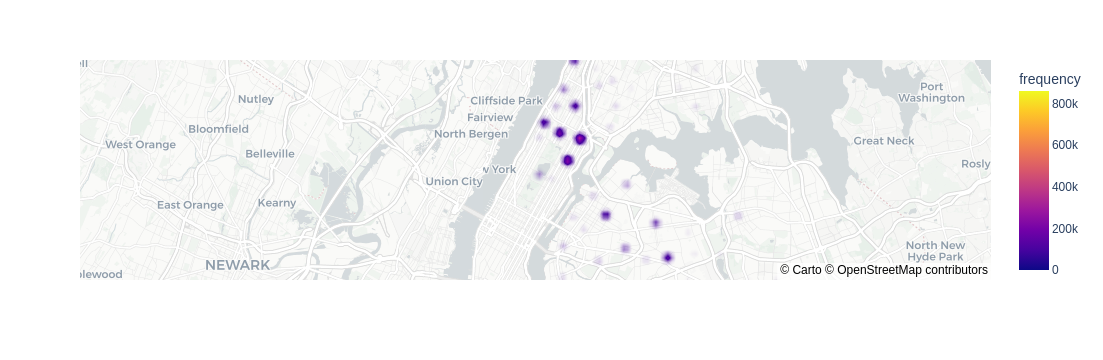

In [59]:
data = taxi[['PULocationID']]
data = pd.merge(data, zones, left_on='PULocationID', right_on='OBJECTID')
data = data.groupby(['latitude', 'longitude']).size().reset_index(name='frequency')

fig = px.density_mapbox(data, lat = 'latitude', lon = 'longitude', z = 'frequency',
                        radius = 8,
                        center = dict(lat = 40.785, lon = -73.968),
                        zoom = 10,
                        mapbox_style = 'carto-positron')

plotly.offline.plot(fig, filename = 'pickup_taxi_heatmap.html', auto_open=False)
fig.show()

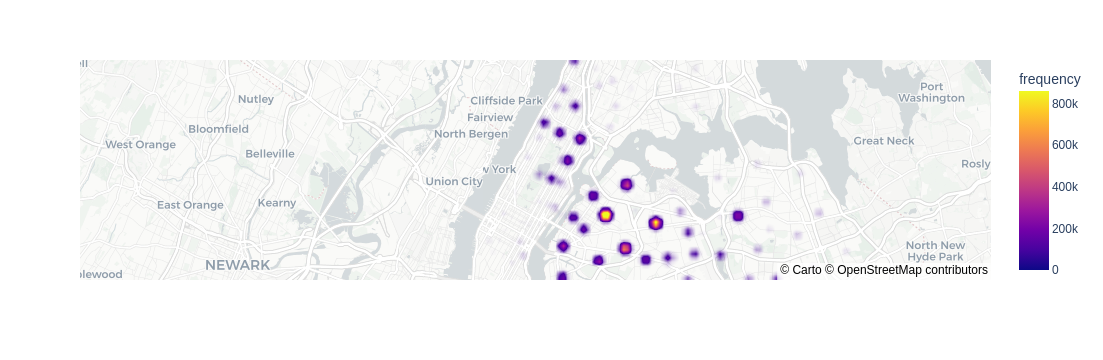

In [60]:
data = taxi[['PULocationID']]
data = pd.merge(data, zones, left_on='PULocationID', right_on='OBJECTID')
data = data.groupby(['latitude', 'longitude']).size().reset_index(name='frequency')

fig = px.density_mapbox(data, lat = 'latitude', lon = 'longitude', z = 'frequency',
                        radius = 8,
                        center = dict(lat = 40.785, lon = -73.968),
                        zoom = 10,
                        mapbox_style = 'carto-positron')

plotly.offline.plot(fig, filename = 'dropoff_taxi_heatmap.html', auto_open=False)
fig.show()